In [2]:
import sys
[sys.path.append(i) for i in ['.', '..']]
import torch
import numpy as np
import sigpy as sp
from sigpy.mri.app import L1WaveletRecon
from prox import Prox
from alg.eig import power_iter
from alg.cg import CG
from linear.linearmaps import LinearMap
from linear.mri import FFTCn, Sense
from linear.basics import Identity, Diff2d, Diff2dframe
import matplotlib.pyplot as plt
import copy
import torchkbnufft as tkbn

In [3]:
# FFT example
device0 = torch.device('cpu')
from skimage.data import shepp_logan_phantom
I_shepp = torch.tensor(shepp_logan_phantom()).to(device0)
Fop = FFTCn((400, 400), (400, 400), (0,1), norm = 'ortho')
k_shepp = Fop*I_shepp

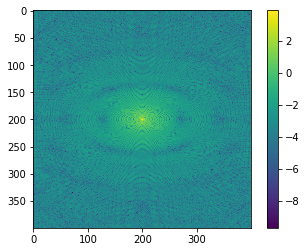

In [4]:
plt.imshow(torch.log(torch.abs(k_shepp)).data.numpy())
plt.colorbar()

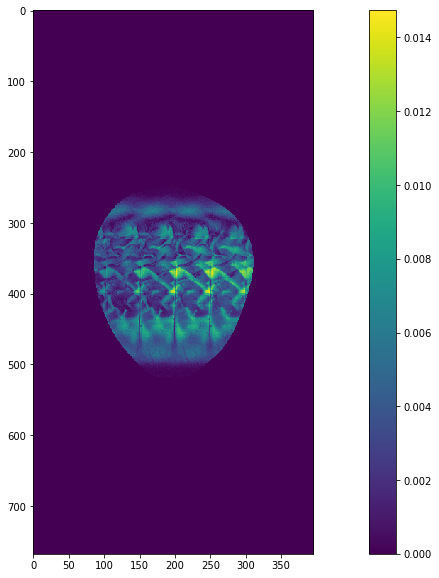

In [5]:
# MRI parallel imaging example (SENSE)
ex_multi = np.load('AXT2_210_6001736_layer11.npz')
device0 = torch.device('cpu')
k_c = torch.tensor(ex_multi['k_r'] + 1j*ex_multi['k_i']).to(device0)/32767.0
s_c = torch.tensor(ex_multi['s_r'] + 1j*ex_multi['s_i']).to(device0)/32767.0
(nc, nh, nw) = s_c.shape
Fop = FFTCn((nc, nh, nw), (nc, nh, nw), (1,2), norm = 'ortho')
I1 = Fop.H*k_c
I1 = torch.sqrt(I1.abs().pow(2).sum(dim=0))
mask = torch.zeros(nh,nw)
mask[:,0:nw:8]=1
Sop = Sense((nh, nw), (nc, nh, nw), (0,1), s_c, mask, batchmode = False)
I0 = Sop.H*k_c
plt.figure(figsize=(20,10))
plt.imshow(torch.abs(I0).data.numpy())
plt.colorbar()

In [6]:
T = Diff2d(Sop.size_in, dim = (0,1))
CG_tik = CG(Sop.H*Sop+0.002*T.H*T, max_iter = 40)
I_tik = CG_tik.run(I0, I0)

residual at 1th iter: 0.013472965961879082
residual at 2th iter: 0.010983632829189065
residual at 3th iter: 0.0013344242973410353
residual at 4th iter: 0.0009766963233064554
residual at 5th iter: 0.00038664271532383166
residual at 6th iter: 0.00046727690694406616
residual at 7th iter: 0.0008937918582546387
residual at 8th iter: 0.00010982040635789292
residual at 9th iter: 0.000643181092018631
residual at 10th iter: 0.0001341825271061601
residual at 11th iter: 0.00015088113926964856
residual at 12th iter: 4.651885707612458e-05
residual at 13th iter: 6.57431604884162e-05
residual at 14th iter: 8.868009858739499e-05
residual at 15th iter: 2.754678621217776e-05
residual at 16th iter: 4.0759915710076214e-05
residual at 17th iter: 1.2495895786337856e-05
residual at 18th iter: 7.733605185370769e-06
residual at 19th iter: 1.9470801010128945e-05
residual at 20th iter: 8.268911436955608e-06
residual at 21th iter: 2.667735367330307e-05
residual at 22th iter: 2.0947005125674917e-05
residual at 23t

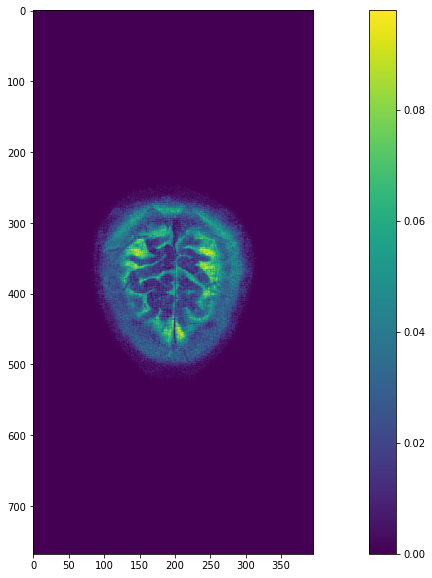

In [7]:
plt.figure(figsize=(20,10))
plt.imshow(torch.abs(I_tik).data.numpy())
plt.colorbar()

In [8]:
# MRI non-Cartesian parallel imaging example

In [ ]:
I0 = 